In [16]:
# import necessry libraries
import sys
import os
import msgpack
import zlib
import numpy as np
import datetime as dt
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
from pathlib import Path

In [2]:
# import files from src
#sys.path.insert(0,"Desktop/Fintech_Bootcamp/Project_2/Project-2/src")



In [3]:
import analysis_helper as ah
import datetime_helper as dh

In [4]:
# define the location of the input file
filename_augmento_topics = Path("../Project-2/Project_2/augmento_topics.msgpack.zlib")
filename_augmento_data = Path("../Project-2/Project_2/augmento_data.msgpack.zlib")
filename_eth_data = Path("../Project-2/Project_2/eth_data.msgpack.zlib")

In [5]:
isExist = os.path.exists(filename_augmento_topics)

print(isExist)

True


In [6]:
def strip_data_by_time(t_data, data, t_min, t_max):
	data = np.array([s for s, t in zip(data, t_data) if t >= t_min and t <= t_max])
	t_data = np.array([t for t in t_data if t >= t_min and t <= t_max])
	return t_data, data

In [7]:
def load_example_data(filename_augmento_topics,
                      filename_augmento_data,
                      filename_eth_data,
                      datetime_start=None,
                      datetime_end=None):

    # load the topics
    with open(filename_augmento_topics, "rb") as f:
        temp = msgpack.unpackb(zlib.decompress(f.read()))
        augmento_topics = {int(k) : v for k, v in temp.items()}
        augmento_topics_inv = {v : int(k) for k, v in temp.items()}
    
    # load the augmento data
    with open(filename_augmento_data, "rb") as f:
        temp = msgpack.unpackb(zlib.decompress(f.read()))
        t_aug_data = np.array([el["t_epoch"] for el in temp], dtype=np.float64)
        aug_data = np.array([el["counts"] for el in temp], dtype=np.int32)

    # load the price data
    with open(filename_eth_data, "rb") as f:
        temp = msgpack.unpackb(zlib.decompress(f.read()))
        eth_data = pd.DataFrame(temp['data'])
        t_price = eth_data['Date'].to_numpy().astype('datetime64')
        t_price_ = t_price.astype('float64')
        price_data = np.array(eth_data['Close'], dtype=np.float64)

	# set the start and end times if they are specified
#    if datetime_start != None:
#        t_start = dh.datetime_to_epoch(datetime_start)
#    else:
        t_start = max(np.min(t_aug_data), np.min(t_price_))

#    if datetime_end != None:
#        t_end = dh.datetime_to_epoch(datetime_end)
#    else:
        t_end = min(np.max(t_aug_data), np.max(t_price_))

    # strip the sentiments and prices outside the shared time range
 #       t_aug_data, aug_data = strip_data_by_time(t_aug_data, aug_data, t_start, t_end)
 #       t_price_, price_data = strip_data_by_time(t_price_, price_data, t_start, t_end)

        return augmento_topics, augmento_topics_inv, t_aug_data, aug_data, t_price_, price_data

In [8]:
# load the example data
all_data = load_example_data(filename_augmento_topics,
                             filename_augmento_data,
                             filename_eth_data)
aug_topics, aug_topics_inv, t_aug_data, aug_data, t_price_, price_data = all_data
all_topics = aug_data.T.astype(float)



C:\Users\kraso\AppData\Local\Temp\ipykernel_6188\3664752054.py:23: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  t_price = eth_data['Date'].to_numpy().astype('datetime64')


In [31]:
t_price_

array([1.5101856e+12, 1.5102720e+12, 1.5103584e+12, ..., 1.6538688e+12,
       1.6539552e+12, 1.6540416e+12])

In [9]:
# Pick Topics
aug_signal_a = aug_data[aug_topics_inv["Bullish"]].astype(np.float64)
aug_signal_b = aug_data[aug_topics_inv["Bearish"]].astype(np.float64)

In [24]:
# define the window size for the sentiment score calculation
n_days = 7
window_size = 24 * n_days

# generate the sentiment score
sent_score = ah.nb_calc_sentiment_score_a(aug_signal_a, aug_signal_b, window_size, window_size)

# define some parameters for the backtest
start_pnl = 1.0
buy_sell_fee = 0.0



In [26]:
def nb_backtest_a(price, sent_score, start_pnl, buy_sell_fee):
	# example backtest with approximate model for long/short contracts
	
	# create an array to hold our pnl, and set the first value
	pnl = np.zeros(price.shape, dtype=np.float64)
	pnl[0] = start_pnl
	
	# for each step, run the market model
	for i_p in range(1, price.shape[0]):
		
		# if sentiment score is positive, simulate long position
		# else if sentiment score is negative, simulate short position
		# else if the sentiment score is 0.0, hold
		# (note that this is a very approximate market simulation!)
		n_sample_delay = 2
		if i_p < n_sample_delay:
			pnl[i_p] = pnl[i_p-1]
		if sent_score[i_p-n_sample_delay] > 0.0:
			pnl[i_p] = (price[i_p] / price[i_p-1]) * pnl[i_p-1]
		elif sent_score[i_p-n_sample_delay] <= 0.0:
			pnl[i_p] = (price[i_p-1] / price[i_p]) * pnl[i_p-1]
		elif sent_score[i_p-n_sample_delay] == 0.0:
			pnl[i_p] = pnl[i_p-1]
		
		# simulate a trade fee if we cross from long to short, or visa versa
		if i_p > 1 and np.sign(sent_score[i_p-1]) != np.sign(sent_score[i_p-2]):
			pnl[i_p] = pnl[i_p] - (buy_sell_fee * pnl[i_p])
	
	return pnl

In [27]:
# run the backtest
pnl = nb_backtest_a(price_data, sent_score, start_pnl, buy_sell_fee)

IndexError: index 93 is out of bounds for axis 0 with size 93

OSError: [Errno 22] Invalid argument

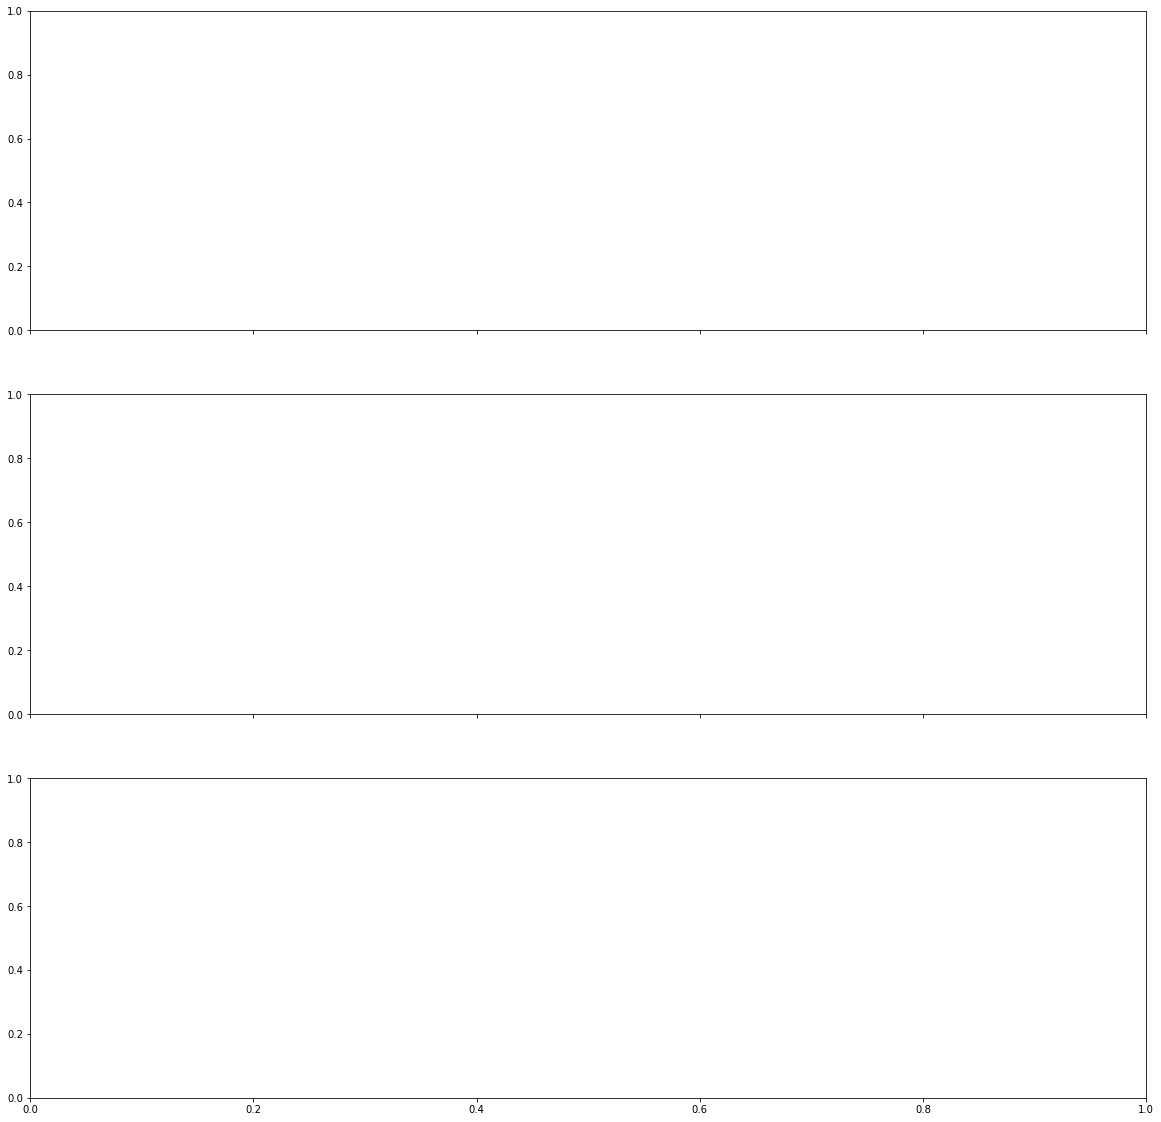

In [22]:
# set up the figure
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20,20))

# initialise some labels for the plot
datenum_aug_data = [md.date2num(dt.datetime.fromtimestamp(el)) for el in t_aug_data]
datenum_price_data = [md.date2num(dt.datetime.fromtimestamp(el)) for el in t_price_]

# plot stuff
ax[0].grid(linewidth=0.4)
ax[1].grid(linewidth=0.4)
ax[2].grid(linewidth=0.4)
ax[0].plot(datenum_price_data, price_data, linewidth=0.5)
ax[1].plot(datenum_aug_data, sent_score, linewidth=0.5)
ax[2].plot(datenum_price_data, pnl, linewidth=0.5)

# label axes
ax[0].set_ylabel("Price")
ax[1].set_ylabel("Seniment score")
ax[2].set_ylabel("PnL")
ax[1].set_ylim([-5.5, 5.5])

ax[0].set_title("4_basic_strategy_example.py")

# generate the time axes
plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax[0]=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d')
ax[0].xaxis.set_major_formatter(xfmt)

# show the plot
plt.show()

In [ ]:
# calculate PNL for a given strategy
# if sentiment positive go long, else go short
# fees are assumed to be 0.75% (taker fee from BITMEX)

def strategy(price_data, signal_a, signal_b, window_1 = 24 * 7, window_2 = 24*7,buy_sell_fee = 0.0075, pnl_0 = 1.0):    
    sent_score = ah.nb_calc_sentiment_score_a(signal_a,signal_b,window_1,window_2)
    pnl = ah.nb_backtest_a(price_data, sent_score, 1.0, buy_sell_fee)
    return pnl

# PNL of various moving window size for a given combination of topics
def window_combination(price_data,top_a,top_b,end_day_x,end_day_y,start_day_x=0,start_day_y=0,buy_sell_fee=0.0075):
    total_comb = np.zeros(shape=(end_day_x,end_day_y))
    print("Calculating...")
    for i in range(start_day_x,end_day_x):
        for j in range(start_day_y,end_day_y):
            total_comb[i][j] = strategy(price_data,top_a,top_b,window_1=24*(i+1),window_2=24*(j+1),buy_sell_fee = 0.0075)[-1]
    print("Done.")
    return total_comb[start_day_x:end_day_x,start_day_y:end_day_y]